In [1]:
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
import kl_ucb_policy

## Scenario 2
Gains moyen faibles avec 10 bras

### Paramètres du scenario

In [3]:
#Params du scenario 2
p = np.array([0.05, 0.02, 0.01, 0.05, 0.02, 0.01, 0.05, 0.02, 0.01, 0.1]) #Param des Bernoulli
K= p.shape[0] #Nb de bras
p_star = np.max(p)
Delta= ( np.ones(K)*p_star ) - p

T= 50000 #Nb max d'iterations

print("Pi:",p)
print("Delta:",Delta)

Pi: [ 0.05  0.02  0.01  0.05  0.02  0.01  0.05  0.02  0.01  0.1 ]
Delta: [ 0.05  0.08  0.09  0.05  0.08  0.09  0.05  0.08  0.09  0.  ]


## Partie UCB

In [4]:
#Initialisation
alpha=3
N3 = np.zeros(K) #Nb de fois ou le bras K a été tiré

Reward_UCB3 = np.zeros((K,T),dtype=np.int) #Recompense avec chaque bras
Action_UCB3 = np.zeros((K,T),dtype=np.int) #Bras choisi a chaque étape

UCB3 = np.zeros(K) #Gain UCB pour chaque bras

In [5]:
#On commence en explorant les K bras au moins une fois
for t in range(K):
    N3[t]=1
    Reward_UCB3[t,t]= np.random.binomial(1, p[t])
    Action_UCB3[t,t]=1

for t in range(K,T):
    #Added slight optimization (sum only up to t)
    for i in range(K):
        UCB3[i] = np.sum(Reward_UCB3[i,:t])/N3[i]+np.sqrt( (alpha*math.log(t))/(2*N3[i]) )
            
    select = np.argmax(UCB3)
    #print("t & select",t, select)
    N3[select]=N3[select]+1
    Action_UCB3[select,t]=1
    Reward_UCB3[select,t]= np.random.binomial(1,p[select])

cumReward=np.cumsum(Reward_UCB3,axis=1) #Reward accumulé pour chaque bras en fonction du temps
totalReward=np.sum(cumReward,axis=0) #Reward sur tout les bras accumulé en fonction du temps

## Partie KL-UCB

In [6]:
%%capture
klucb = kl_ucb_policy.KLUCBPolicy(K)

#start_time = time.time()

klucb.reset()
actions_klucb = np.zeros((K, T), dtype=np.int)
rewards_klucb = np.zeros((K, T), dtype=np.int)

for t in range(T):
    arm_klucb = klucb.select_next_arm()
    #print("arm :", arm)
    actions_klucb[arm_klucb,t] = 1
    rewards_klucb[arm_klucb,t] = np.random.binomial(1, p[arm_klucb])
    klucb.update_state(arm_klucb, rewards_klucb[arm_klucb,t])
        
cum_reward_klucb = np.cumsum(rewards_klucb, axis=1) #Reward accumulé pour chaque bras en fonction du temps
total_reward_klucb = np.sum(cum_reward_klucb, axis=0) #Reward sur tout les bras accumulé en fonction du temps

#time_spent = time.time() - start_time

t & Reward (total) UCB : 49999 3664
t & Reward (total) KL-UCB : 49999 4807


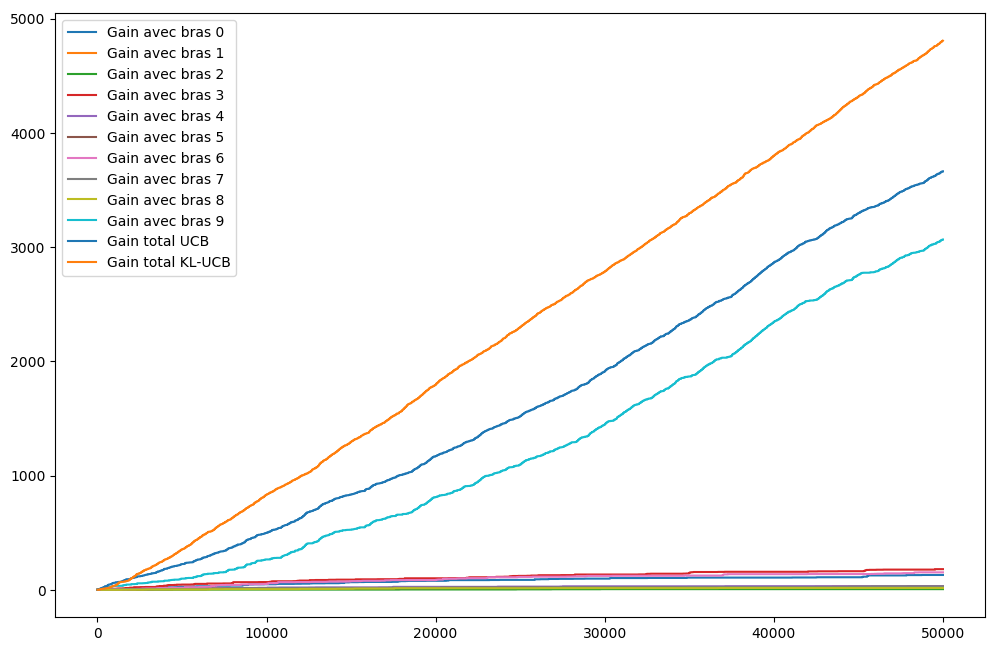

In [7]:
print("t & Reward (total) UCB :",t, totalReward[t] )
print("t & Reward (total) KL-UCB :",t, total_reward_klucb[t] )
   
fig=plt.figure(figsize=(12,8))
##fig=plt.figure()  
ax1 = fig.add_subplot(1,1,1)
for i in range (K):
##ax1.plot(c_error,marker='.',linestyle='-',label='Online avec gradient à pas constant')
    ax1.plot(cumReward[i,:],linestyle='-',label='Gain avec bras '+str(i))
#ax1.plot(totalReward[1,:],linestyle='-',label='Gain avec bras 2')
ax1.plot(totalReward[:],linestyle='-',label='Gain total UCB')
ax1.plot(total_reward_klucb[:],linestyle='-',label='Gain total KL-UCB')
ax1.legend(loc='best')
plt.show()

t & Pseudo-Regret : 49999 1228.34


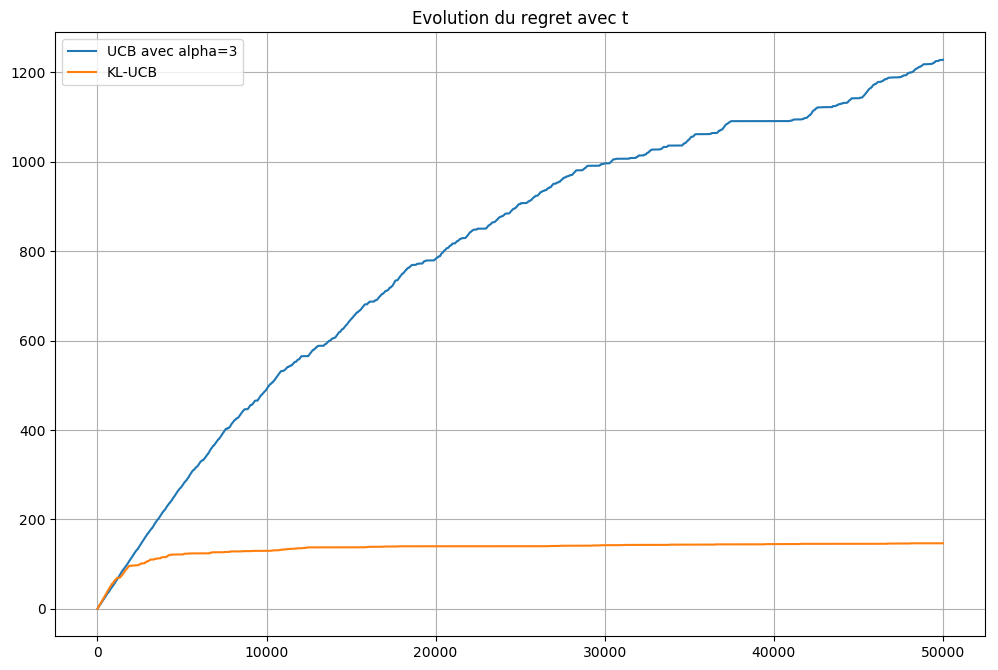

In [8]:
#UCB
totalAction=np.cumsum(Action_UCB3,axis=1) #Nb d'actions accumulé sur chaque bras
cumRegret=np.dot(Delta,totalAction[:,:]) #Regret accumulé
#KL-UCB
total_action_klucb = np.cumsum(actions_klucb, axis=1) #Nb d'actions accumulé sur chaque bras
cum_regret_klucb = np.dot(Delta, total_action_klucb[:,:]) #Regret accumulé

print("t & Pseudo-Regret :",t,cumRegret[T-1])

fig=plt.figure(figsize=(12,8))
##fig=plt.figure()  
ax1 = fig.add_subplot(1,1,1)
ax1.plot(cumRegret[:],linestyle='-', label='UCB avec alpha=3')
ax1.plot(cum_regret_klucb[:],linestyle='-', label='KL-UCB')
ax1.legend(loc='best')
ax1.grid()
ax1.set_title('Evolution du regret avec t')
#ax1.xscale('log')
plt.show()

In [9]:
#UCB
T=5000
runs=100
regret_list_ucb = []
start_time = time.time()

for run in range(runs):
    if(run == 0 or run % 10 == 0):
        print("run =", run)
    
    #ucb Params Iinitialization
    N3 = np.zeros(K) #Nb de fois ou le bras K a été tiré
    Reward_UCB3 = np.zeros((K,T),dtype=np.int) #Recompense avec chaque bras
    Action_UCB3 = np.zeros((K,T),dtype=np.int) #Bras choisi a chaque étape

    UCB3 = np.zeros(K) #Gain UCB pour chaque bras
    N = np.zeros(K) #Nb de fois ou le bras 1 ou 2 a été tiré
    rewards_ucb = np.zeros((K, T), dtype=np.int) #Recompense avec chaque bras
    action_ucb = np.zeros((K, T), dtype=np.int) #Bras choisi a chaque étape
    ucb = np.zeros(K) #ucb pour chaque bras

    #On commence en explorant les K bras au moins une fois
    for t in range(K):
        N3[t]=1
        Reward_UCB3[t,t]= np.random.binomial(1, p[t])
        Action_UCB3[t,t]=1

    for t in range(K,T):
        for i in range(K):
            UCB3[i] = np.sum(Reward_UCB3[i,:t])/N3[i]+np.sqrt( (alpha*math.log(t))/(2*N3[i]) )
            
        select = np.argmax(UCB3)
        #print("t & select",t, select)
        N3[select]=N3[select]+1
        Action_UCB3[select,t]=1
        Reward_UCB3[select,t]= np.random.binomial(1,p[select])

    cumReward=np.cumsum(Reward_UCB3,axis=1) #Reward accumulé pour chaque bras en fonction du temps
    totalReward=np.sum(cumReward,axis=0) #Reward sur tout les bras accumulé en fonction du temps
    totalAction=np.cumsum(Action_UCB3,axis=1) #Nb d'actions accumulé sur chaque bras
    cumRegret=np.dot(Delta,totalAction[:,:]) #Regret accumulé
    Regret=cumRegret[T-1]
    #print("Run, regret:",run,Regret)
    regret_list_ucb.append(Regret)

print("Time for UCB, with T =", T, ", runs =", runs, ":", (time.time() - start_time), "seconds")

run = 0
run = 10
run = 20
run = 30
run = 40
run = 50
run = 60
run = 70
run = 80
run = 90
Time for UCB, with T = 5000 , runs = 100 : 242.76784682273865 seconds


In [10]:
%%capture
#KL-UCB
klucb = kl_ucb_policy.KLUCBPolicy(K)

regret_list_klucb = []
start_time = time.time()

for run in range(runs):
    if(run == 0 or run % 10 == 0):
        print("run =", run)
        
    klucb.reset()
    actions_klucb = np.zeros((K, T), dtype=np.int)
    rewards_klucb = np.zeros((K, T), dtype=np.int)

    for t in range(T):
        arm_klucb = klucb.select_next_arm()
        #print("arm :", arm)
        actions_klucb[arm_klucb,t] = 1
        rewards_klucb[arm_klucb,t] = np.random.binomial(1, p[arm_klucb])
        klucb.update_state(arm_klucb, rewards_klucb[arm_klucb,t])
        
    cumReward=np.cumsum(rewards_klucb,axis=1) #Reward accumulé pour chaque bras en fonction du temps
    totalReward=np.sum(cumReward,axis=0) #Reward sur tout les bras accumulé en fonction du temps
    totalAction=np.cumsum(actions_klucb,axis=1) #Nb d'actions accumulé sur chaque bras
    cumRegret=np.dot(Delta,totalAction[:,:]) #Regret accumulé
    Regret=cumRegret[T-1]
    #print("Run, regret:",run,Regret)
    regret_list_klucb.append(Regret)

time_spent = time.time() - start_time

In [11]:
print("Time for KL-UCB, with T =", T, ", runs =", runs, ":", (time_spent), "seconds")

Time for KL-UCB, with T = 5000 , runs = 100 : 1675.7325603961945 seconds


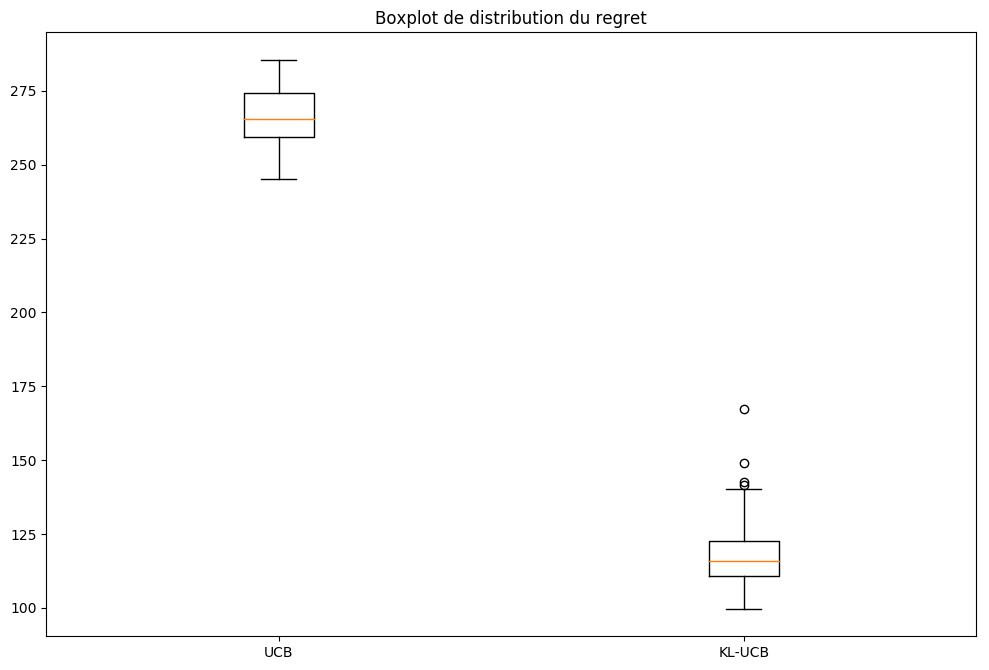

In [12]:
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
ax.boxplot([regret_list_ucb, regret_list_klucb])
ax.set_xticklabels(['UCB', 'KL-UCB'])
#ax.legend(loc='best')
ax.set_title('Boxplot de distribution du regret')
plt.show()